In [1]:
%load_ext sppl.magics
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%sppl hmm
from sppl.sym_util import binspace

n = 100
p_transition = [.2, .8]
mu_x = [[5, 7], [5, 15]]
mu_y = [[5, 8], [3, 8]]

X = array(n)
Y = array(n)
Z = array(n)

seperated ~= bernoulli(p=.4)
switch (seperated) cases (s in [0,1]):
    
    # Sample initial point.
    Z[0] ~= bernoulli(p=.5)
    switch (Z[0]) cases (z in [0, 1]):
        X[0] ~= norm(loc=mu_x[s][z])
        Y[0] ~= poisson(mu=mu_y[s][z])

    for i in range(1, n):
        switch (Z[i-1]) cases (z in [0, 1]):
            Z[i] ~= bernoulli(p=p_transition[z])
            switch (Z[i]) cases (z in [0, 1]):
                X[i] ~= norm(loc=mu_x[s][z])
                Y[i] ~= poisson(mu=mu_y[s][z])

In [3]:
namespace = %sppl_get_namespace hmm
hmm = namespace.hmm
X = namespace.X
Y = namespace.Y
Z = namespace.Z

In [4]:
# Generate a prior sample
simulation = hmm.sample(N=1, prng=np.random.RandomState(216))[0]
xs = [float(simulation[x]) for x in namespace.X]
ys = [float(simulation[y]) for y in namespace.Y]
zs = [int(simulation[z]) for z in namespace.Z]

In [5]:
# Convert simulation to an observation
from functools import reduce
obs_Y = [Y[i] << {int(y)} for i, y in enumerate(ys)]
obs_X = [((x-.1) < X[i]) < (x+.1) for i, x in enumerate(xs)]
observation = reduce(lambda s, e: s & e, obs_X + obs_Y)

In [6]:
modelc = hmm.condition(observation)

In [7]:
p_posterior = [modelc.prob(Z[i] << {1}) for i in range(100)]

In [8]:
from matplotlib.patches import Rectangle

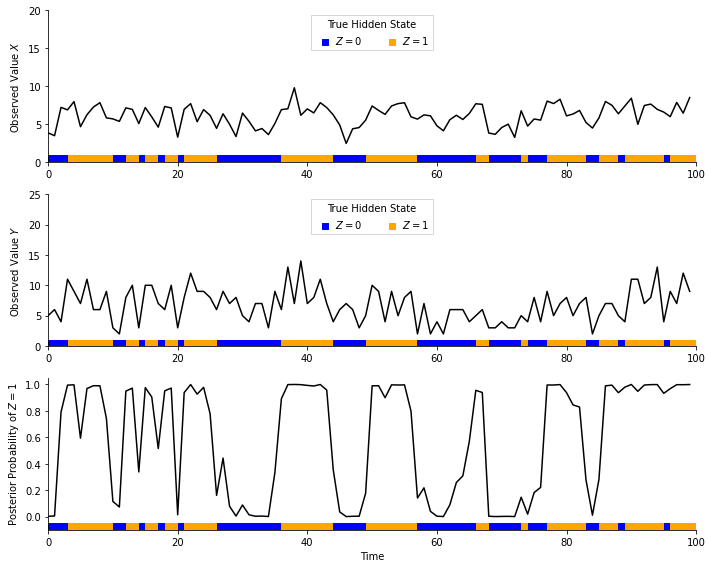

In [9]:
ns = np.arange(namespace.n)

zs = np.asarray(zs)
xs = np.asarray(xs)
ys = np.asarray(ys)
s = 0
colors = ['blue', 'orange']

fig, axes = plt.subplots(nrows=3)
axes[0].plot(ns, xs, color='k')
axes[0].scatter(ns[zs==0], xs[zs==0], color=colors[0], s=s)
axes[0].scatter(ns[zs==1], xs[zs==1], color=colors[1], s=s)
axes[0].set_ylim([0, 20])
axes[0].set_ylabel('Observed Value $X$')
# Hidden State.
for i, j in zip(ns, zs):
    shape = Rectangle((i, 0), 1, 1, color=colors[j])
    axes[0].add_patch(shape)
axes[0].scatter([], [], marker='s', color=colors[0], label='$Z = 0$')
axes[0].scatter([], [], marker='s', color=colors[1], label='$Z = 1$')
axes[0].legend(loc='upper center', handletextpad=0, title='True Hidden State', ncol=2, fancybox=False)

axes[1].plot(ns, ys, color='k')
axes[1].scatter(ns[zs==0], ys[zs==0], color=colors[0], s=s)
axes[1].scatter(ns[zs==1], ys[zs==1], color=colors[1], s=s)
axes[1].set_ylim([0, 25])
axes[1].set_ylabel('Observed Value $Y$')
for i, j in zip(ns, zs):
    shape = Rectangle((i, 0), 1, 1, color=colors[j])
    axes[1].add_patch(shape)
axes[1].scatter([], [], marker='s', color=colors[0], label='$Z = 0$')
axes[1].scatter([], [], marker='s', color=colors[1], label='$Z = 1$')
axes[1].legend(loc='upper center', handletextpad=0, title='True Hidden State', ncol=2, fancybox=False)


# axes[2].plot(ns, zs, color='k', label='True Value', linewidth=1)
axes[2].plot(ns, p_posterior, color='k', label='Posterior\nProbability\nof $Z=1$')
axes[2].set_ylim([-.1, None])
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Posterior Probability of $Z = 1$')
# axes[2].legend(loc='upper center', handlelength=1, handletextpad=.5, fancybox=False)
for i, j in zip(ns, zs):
    shape = Rectangle((i, -.1), 1, .05, color=colors[j])
    axes[2].add_patch(shape)
    
for ax in axes:
    ax.set_xlim([0, 100])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.set_size_inches(10, 8)
fig.set_tight_layout(True)
fig.align_ylabels(axes)